# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

This project accepts any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project

![Sample Dog Output](images/sample_dog_output.png)




## Step 0: Import Datasets


In [4]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("D:/lfw/*/*"))
dog_files = np.array(glob("D:/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


## Step 1: Detect Humans 
### Using openCV


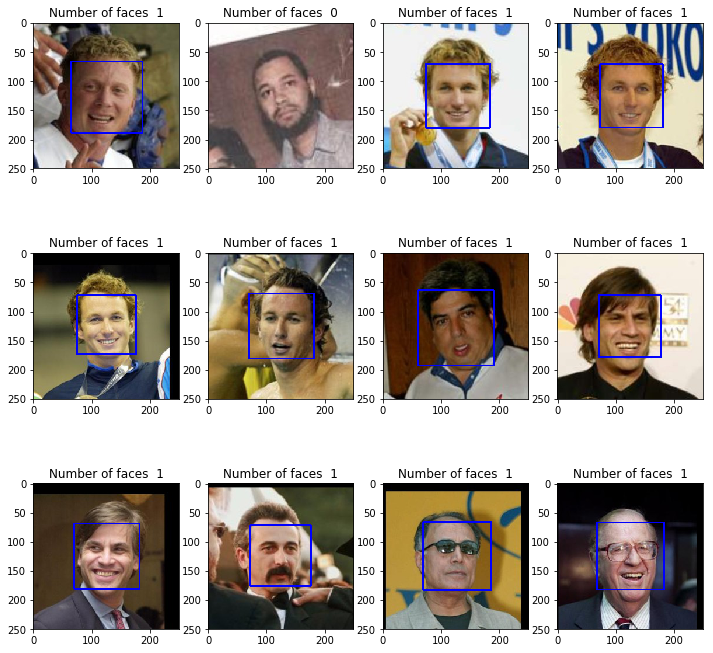

In [32]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('D:/haarcascades/haarcascade_frontalface_alt.xml')

col = 4
row = 3
fig = plt.figure(figsize=(12, 12))

ax = []

for i in range(1, row*col + 1):
    img = cv2.imread(human_files[i])
    
    ax.append(fig.add_subplot(row, col, i))
    
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)
    
    ax[i-1].set_title('Number of faces  {}'.format(len(faces)))
    
    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    
plt.show() 

## Human Face Detetor

In [33]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

## Assess the Human Face Detector

In [35]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
total = 0
for i in human_files_short:
    total += face_detector(i)

print("Percentile of detected faces in human images : ", total / len(human_files_short))

total = 0
for i in dog_files_short:
    total += face_detector(i)

print("Percentile of detected faces in dog images : ", total / len(dog_files_short))



Percentile of detected faces in human images :  0.96
Percentile of detected faces in dog images :  0.18


## Step 2: Detect Dogs
The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories]

In [36]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# define VGG16 model
VGG16 = models.vgg16(pretrained=True)


# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [37]:
def load_and_preprocess(img_path):
    image = Image.open(img_path).convert('RGB')
    
    in_transform = transforms.Compose([
        transforms.Resize(size=(250, 250)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image
    
    

## Making Predictions with a Pre-trained Model

In [38]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''

    image = load_and_preprocess(img_path)
    
    if use_cuda:
        image = image.cuda()
        

        
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    prediction = VGG16(image)
    
    index = prediction.cpu().data.numpy().argmax() # prediction will be the index of the class label with the largest value.

    return  index # predicted class index



## Write a Dog Detector

In [39]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    VGG16_predict(img_path)
    
    if VGG16_predict(img_path) <=268 and VGG16_predict(img_path) >= 151:
        return True
    
    return False # true/false

### Assess the Dog Detector

In [40]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

total = 0
for v in dog_files_short:
    total += int(dog_detector(v))

print("The ratio is: {} / {}".format(total, len(dog_files_short)))

The ratio is: 94 / 100


In [41]:
human_face = 0
for v in human_files_short:
    human_face += int(dog_detector(v))
print("The ratio is: {} / {}".format(human_face, len(human_files_short)))

The ratio is: 1 / 100


## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  